In [12]:
import pandas as pd
from pandas import DataFrame
from unicodedata import category

data = pd.read_csv("D:/Elevate Lab/Task/project phase 1/ecommerce_returns_dataset.csv")
df= DataFrame(data)
print(df)

     order_id  product_id     category    supplier  price  quantity  \
0           1         202       Beauty  Supplier D   2608         3   
1           2         279  Electronics  Supplier C    540         2   
2           3         192       Beauty  Supplier C   3017         2   
3           4         114         Home  Supplier B   2696         2   
4           5         206      Fashion  Supplier D   1925         4   
..        ...         ...          ...         ...    ...       ...   
995       996         210         Home  Supplier A   1337         2   
996       997         210  Electronics  Supplier C   2727         1   
997       998         133  Electronics  Supplier B   4317         2   
998       999         210  Electronics  Supplier A   3620         4   
999      1000         107      Fashion  Supplier B   4978         3   

     order_date customer_location marketing_channel  returned  
0    2023-01-01             Delhi          Referral         0  
1    2023-01-02    

In [13]:
# Basic cleaning
print(df.duplicated())
print(df.isnull().sum())
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

#convert data types
df["order_date"] = pd.to_datetime(df["order_date"])
df["returnerd"] = df["returned"].astype(int)

#create return rate flag
df["return_flag"] = df["returned"]

print(df)

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool
order_id             0
product_id           0
category             0
supplier             0
price                0
quantity             0
order_date           0
customer_location    0
marketing_channel    0
returned             0
dtype: int64
     order_id  product_id     category    supplier  price  quantity  \
0           1         202       Beauty  Supplier D   2608         3   
1           2         279  Electronics  Supplier C    540         2   
2           3         192       Beauty  Supplier C   3017         2   
3           4         114         Home  Supplier B   2696         2   
4           5         206      Fashion  Supplier D   1925         4   
..        ...         ...          ...         ...    ...       ...   
995       996         210         Home  Supplier A   1337         2   
996       997       

In [14]:
#Return % by category

category_return = df.groupby("category")["returned"].mean().reset_index()
category_return["return_%"]= category_return['returned']*100
print(category_return)


      category  returned   return_%
0       Beauty  0.062500   6.250000
1  Electronics  0.052239   5.223881
2      Fashion  0.533597  53.359684
3         Home  0.043137   4.313725


In [15]:
#Return %  by supplier
supplier_return = df.groupby("supplier")["returned"].mean().reset_index()
print(supplier_return)


     supplier  returned
0  Supplier A  0.161290
1  Supplier B  0.148289
2  Supplier C  0.189655
3  Supplier D  0.198444


In [16]:
#Return % by marketing channel
channel_return = df.groupby("marketing_channel")["returned"].mean().reset_index()
print(channel_return)

  marketing_channel  returned
0               Ads  0.444444
1             Email  0.082353
2           Organic  0.100000
3          Referral  0.103846


In [17]:
#Return rate by Region
customer_location_return= df.groupby("customer_location")["returned"].mean().reset_index()
customer_location_return["return_%"]= customer_location_return["returned"]*100
print(customer_location_return)

  customer_location  returned   return_%
0         Bangalore  0.200000  20.000000
1           Chennai  0.135135  13.513514
2             Delhi  0.182266  18.226601
3         Hyderabad  0.189320  18.932039
4            Mumbai  0.159204  15.920398


In [18]:
#Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

#Encode categorical columns
le = LabelEncoder()
for col in ["category", "supplier", "marketing_channel"]:
    df[col] = le.fit_transform(df[col])

#Features & target
X = df[["price", "quantity", "category", "supplier", "marketing_channel"]]
y = df["returned"]

#Train model,
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.85      0.97      0.90       243
           1       0.65      0.26      0.38        57

    accuracy                           0.83       300
   macro avg       0.75      0.62      0.64       300
weighted avg       0.81      0.83      0.80       300

ROC AUC: 0.8426828387842032


In [19]:
#increase recall for returns
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

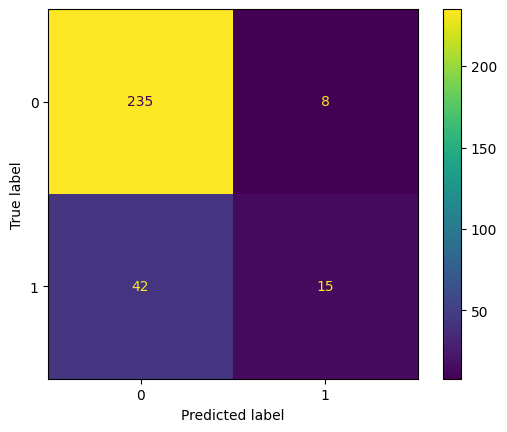

In [20]:
#improves recall for class 1
y_probs = model.predict_proba(X_test)[:,1]
y_pred_custom = (y_probs >= 0.3).astype(int)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


✅ Insights to write:

1. Fashion category shows significantly higher return rates, indicating sizing/expectation issues.

2. Supplier C & D consistently contribute to higher returns → supplier quality review required.

3. Paid Ads channel has the highest return rate, suggesting impulse buying behavior.

4. Logistic regression identifies price and marketing channel as key predictors of returns.

In [21]:
print(df.columns)


Index(['order_id', 'product_id', 'category', 'supplier', 'price', 'quantity',
       'order_date', 'customer_location', 'marketing_channel', 'returned',
       'returnerd', 'return_flag'],
      dtype='object')


In [22]:
# Ensure probability exists
df["return_probability"] = model.predict_proba(X)[:, 1]

# Create risk levels safely
df["return_risk_level"] = pd.cut(
    df["return_probability"],
    bins=[0, 0.3, 0.6, 1.01],   # 1.01 avoids edge issues
    labels=["Low", "Medium", "High"],
    include_lowest=True
)

# Check values
print(df["return_risk_level"].value_counts())


return_risk_level
Low       443
High      291
Medium    266
Name: count, dtype: int64


In [23]:
df["return_probability"] = model.predict_proba(X)[:,1]

df["return_risk_level"] = pd.cut(
    df["return_probability"],
    bins=[0, 0.3, 0.6, 1],
    labels=["Low", "Medium", "High"]
)

df.to_csv("powerbi_return_risk_data.csv", index=False)


In [24]:
import os
print(os.getcwd())


D:\data analyst\PythonProject\.venv\Lib
